# Convolutional autoencoders and LSTMs for PDE surrogates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D

from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model

from scipy.signal import savgol_filter

import seaborn as sns
import re
import matplotlib as mpl
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import matplotlib.ticker as mtick

/home/rmlans/anaconda3/envs/tf2_env/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


### Grab data from Github (for Colab)

In [2]:
!wget -O train.npy https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/AE_and_GAN/Science_Data/train.npy?raw=true
!wget -O validation.npy https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/AE_and_GAN/Science_Data/validation.npy?raw=true
!wget -O SWE_CAE_Weights.h5 https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/AE_and_GAN/saved_models/SWE_CAE_Weights.h5?raw=true
!wget -O SWE_LSTM_Weights.h5 https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/AE_and_GAN/saved_models/SWE_LSTM_Weights.h5?raw=true

--2020-08-06 22:50:48--  https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/AE_and_GAN/Science_Data/train.npy?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/argonne-lcf/ATPESC_MachineLearning/raw/master/AE_and_GAN/Science_Data/train.npy [following]
--2020-08-06 22:50:48--  https://github.com/argonne-lcf/ATPESC_MachineLearning/raw/master/AE_and_GAN/Science_Data/train.npy
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/argonne-lcf/ATPESC_MachineLearning/master/AE_and_GAN/Science_Data/train.npy [following]
--2020-08-06 22:50:49--  https://raw.githubusercontent.com/argonne-lcf/ATPESC_MachineLearning/master/AE_and_GAN/Science_Data/train.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.28.133
Conne

### Load SWE snapshot data

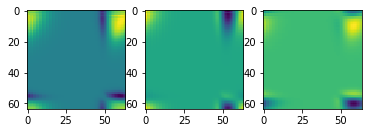

In [2]:
swe_data = np.transpose(np.load('train.npy'))
swe_data_v = np.transpose(np.load('validation.npy'))

swe_train_data = np.zeros(shape=(400,64,64,3)) # Channels last
swe_valid_data = np.zeros(shape=(400,64,64,3)) # Channels last

for i in range(np.shape(swe_data)[0]):
    temp_1 = swe_data[i,0:64*64].reshape(64,64)
    temp_2 = swe_data[i,64*64:2*64*64].reshape(64,64)
    temp_3 = swe_data[i,2*64*64:3*64*64].reshape(64,64)
    swe_train_data[i,:,:,0] = np.transpose(temp_1[:,:])
    swe_train_data[i,:,:,1] = np.transpose(temp_2[:,:])
    swe_train_data[i,:,:,2] = np.transpose(temp_3[:,:])
    
for i in range(np.shape(swe_data)[0]):
    temp_1 = swe_data_v[i,0:64*64].reshape(64,64)
    temp_2 = swe_data_v[i,64*64:2*64*64].reshape(64,64)
    temp_3 = swe_data_v[i,2*64*64:3*64*64].reshape(64,64)
    swe_valid_data[i,:,:,0] = np.transpose(temp_1[:,:])
    swe_valid_data[i,:,:,1] = np.transpose(temp_2[:,:])
    swe_valid_data[i,:,:,2] = np.transpose(temp_3[:,:])
    

# Just to keep things simple
swe_train_data = swe_train_data[0:200,:,:,:]
swe_valid_data = swe_valid_data[0:200,:,:,:]

for j in range(3):
    swe_train_data[:,:,:,j] = (swe_train_data[:,:,:,j] - np.min(swe_train_data[:,:,:,0]))/(np.max(swe_train_data[:,:,:,0])-np.min(swe_train_data[:,:,:,0]))
    swe_valid_data[:,:,:,j] = (swe_valid_data[:,:,:,j] - np.min(swe_valid_data[:,:,:,0]))/(np.max(swe_valid_data[:,:,:,0])-np.min(swe_valid_data[:,:,:,0]))

# Visualize one time instance
time = 20
fig, ax = plt.subplots(nrows=1,ncols=3)

ax[0].imshow(swe_valid_data[time,:,:,0])
ax[1].imshow(swe_valid_data[time,:,:,1])
ax[2].imshow(swe_valid_data[time,:,:,2])
plt.show()

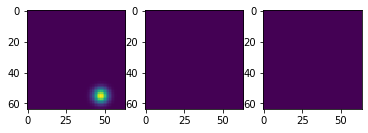

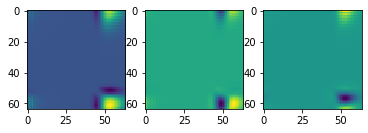

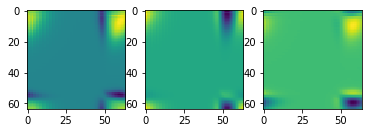

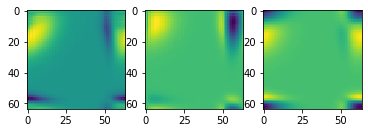

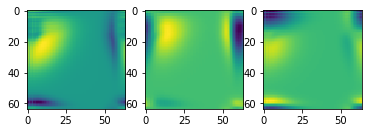

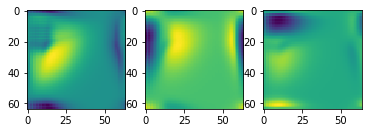

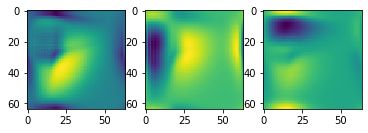

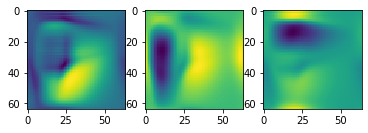

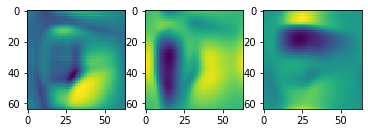

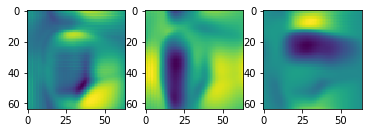

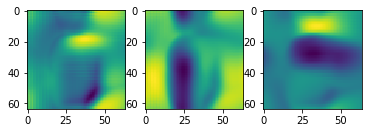

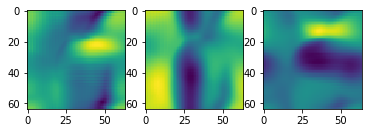

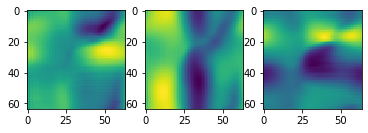

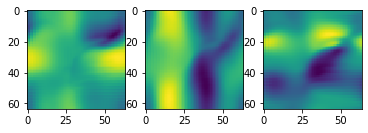

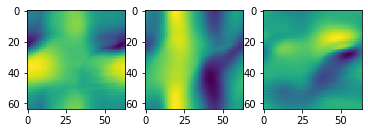

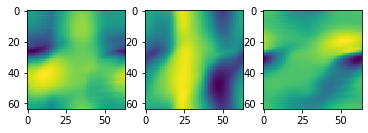

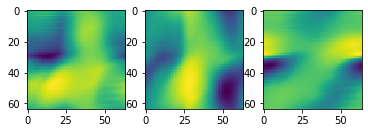

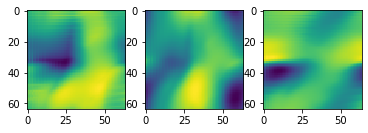

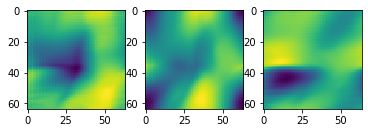

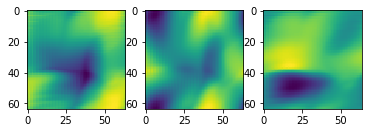

In [4]:
# Visualize multiple time instances
for time in range(0,200,10):
    fig, ax = plt.subplots(nrows=1,ncols=3)
    ax[0].imshow(swe_train_data[time,:,:,0])
    ax[1].imshow(swe_train_data[time,:,:,1])
    ax[2].imshow(swe_train_data[time,:,:,2])
    plt.show()

### ML Presets and Custom Functions

In [4]:
mode = 'test'
lrate = 0.001

def mean_absolute_error(y_pred,y_true):
    return K.mean(K.abs(y_true-y_pred))

def max_absolute_error(y_pred,y_true):
    return K.max(K.abs(y_true-y_pred))

### Autoencoder

In [5]:
# Define recursive model architecture
weights_filepath = 'SWE_CAE_Weights.h5'
## Encoder
encoder_inputs = Input(shape=(64,64,3),name='Field')
# Encode   
x = Conv2D(30,kernel_size=(3,3),activation='relu',padding='same')(encoder_inputs)
enc_l2 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(20,kernel_size=(3,3),activation='relu',padding='same')(enc_l2)
enc_l3 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(10,kernel_size=(3,3),activation='relu',padding='same')(enc_l3)
enc_l4 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(15,kernel_size=(3,3),activation='relu',padding='same')(enc_l4)
enc_l5 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(1,kernel_size=(3,3),activation=None,padding='same')(enc_l5)
encoded = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

encoder = Model(inputs=encoder_inputs,outputs=encoded)
    
## Decoder
decoder_inputs = Input(shape=(2,2,1),name='decoded')

x = Conv2D(1,kernel_size=(3,3),activation='relu',padding='same')(decoder_inputs)
dec_l1 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(5,kernel_size=(3,3),activation='relu',padding='same')(dec_l1)
dec_l2 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(10,kernel_size=(3,3),activation='relu',padding='same')(dec_l2)
dec_l3 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(20,kernel_size=(3,3),activation='relu',padding='same')(dec_l3)
dec_l4 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(30,kernel_size=(3,3),activation='relu',padding='same')(dec_l4)
dec_l5 = UpSampling2D(size=(2, 2))(x)

decoded = Conv2D(3,kernel_size=(3,3),activation=None,padding='same')(dec_l5)
    
decoder = Model(inputs=decoder_inputs,outputs=decoded)

## Autoencoder
ae_outputs = decoder(encoder(encoder_inputs))
  
model = Model(inputs=encoder_inputs,outputs=ae_outputs,name='CAE')
   
# design network
my_adam = optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

checkpoint = ModelCheckpoint(weights_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint]

# fit network
model.compile(optimizer=my_adam,loss='mean_squared_error',metrics=[mean_absolute_error,max_absolute_error])    
model.summary()

num_epochs = 5000
batch_size = 4

if mode == 'train':
    train_history = model.fit(x=swe_train_data, y=swe_train_data, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list)

Model: "CAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Field (InputLayer)           [(None, 64, 64, 3)]       0         
_________________________________________________________________
model (Model)                (None, 2, 2, 1)           9571      
_________________________________________________________________
model_1 (Model)              (None, 64, 64, 3)         8583      
Total params: 18,154
Trainable params: 18,154
Non-trainable params: 0
_________________________________________________________________


### Check accuracy

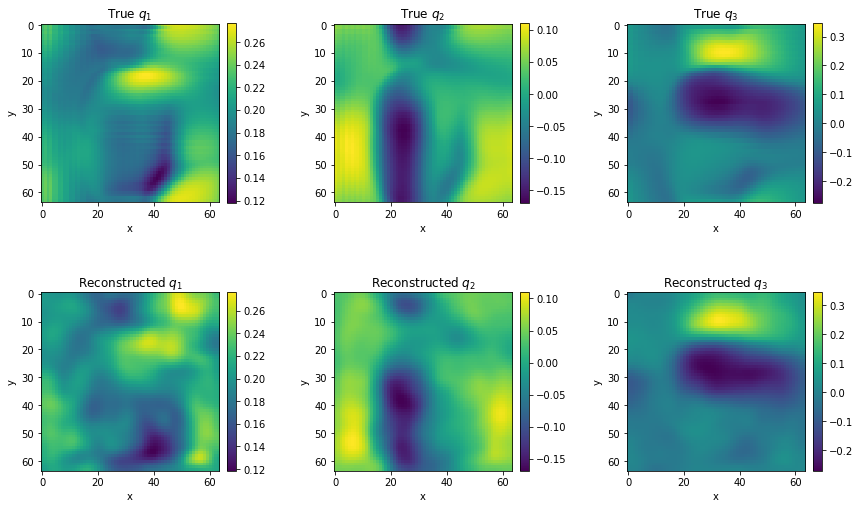

In [6]:
time = 100

model.load_weights(weights_filepath)
from scipy.ndimage import gaussian_filter
recoded_1 = model.predict(swe_train_data[time:time+1,:,:,:])

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(14,12))

cs1 = ax[0,0].imshow(swe_train_data[time,:,:,0],label='input')
ax[1,0].imshow(gaussian_filter(recoded_1[0,:,:,0],sigma=2),label='decoded')

cs2 = ax[0,1].imshow(swe_train_data[time,:,:,1],label='input')
ax[1,1].imshow(gaussian_filter(recoded_1[0,:,:,1],sigma=2),label='decoded')

cs3 = ax[0,2].imshow(swe_train_data[time,:,:,2],label='input')
ax[1,2].imshow(gaussian_filter(recoded_1[0,:,:,2],sigma=2),label='decoded')

for i in range(2):
    for j in range(3):
        ax[i,j].set_xlabel('x')
        ax[i,j].set_ylabel('y')
        
fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(cs1,ax=ax[1,0],fraction=0.046, pad=0.04)

fig.colorbar(cs2,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1,1],fraction=0.046, pad=0.04)

fig.colorbar(cs3,ax=ax[0,2],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[1,2],fraction=0.046, pad=0.04)


ax[0,0].set_title(r'True $q_1$')
ax[0,1].set_title(r'True $q_2$')
ax[0,2].set_title(r'True $q_3$')

ax[1,0].set_title(r'Reconstructed $q_1$')
ax[1,1].set_title(r'Reconstructed $q_2$')
ax[1,2].set_title(r'Reconstructed $q_3$')

plt.subplots_adjust(wspace=0.5,hspace=-0.3)
plt.show()

### Generate encoded data for LSTM learning

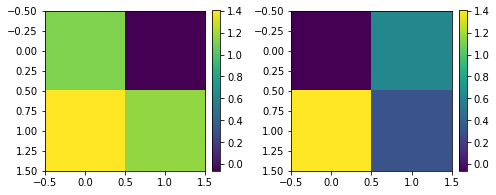

In [7]:
encoded = K.eval(encoder(swe_train_data[:,:,:,:].astype('float32')))
# Visualize latent space
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(7,6))
time = 98
cs = ax[0].imshow(encoded[time,:,:,0])
fig.colorbar(cs,ax=ax[0],fraction=0.046, pad=0.04)

time = 198
ax[1].imshow(encoded[time,:,:,0])
fig.colorbar(cs,ax=ax[1],fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### Train LSTM

In [8]:
time_window = 15 # The window size of the LSTM

encoded = encoded.reshape(200,4)
lstm_training_data = np.copy(encoded)
num_train_snapshots = 1
total_size = np.shape(lstm_training_data)[0]

# Shape the inputs and outputs
input_seq = np.zeros(shape=(total_size-time_window,time_window,4))
output_seq = np.zeros(shape=(total_size-time_window,4))

# Setting up inputs
sample = 0
for t in range(time_window,total_size):
    input_seq[sample,:,:] = lstm_training_data[t-time_window:t,:]
    output_seq[sample,:] = lstm_training_data[t,:]
    sample = sample + 1

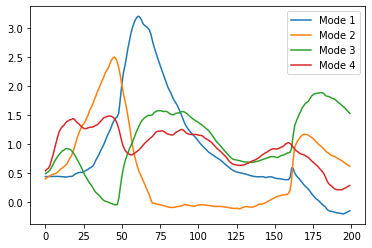

In [9]:
plt.figure()
plt.plot(encoded[:,0],label='Mode 1')
plt.plot(encoded[:,1],label='Mode 2')
plt.plot(encoded[:,2],label='Mode 3')
plt.plot(encoded[:,3],label='Mode 4')
plt.legend()
plt.show()

In [11]:
# Model architecture
lstm_model = models.Sequential()
lstm_model.add(LSTM(20,input_shape=(time_window, 4),return_sequences=True))  #
lstm_model.add(LSTM(20,input_shape=(time_window, 4),return_sequences=False))  #
lstm_model.add(Dense(4, activation=None))

# training parameters
num_epochs = 3000
batch_size = 64


# design network
lstm_filepath = './SWE_LSTM_Weights.h5'
lstm_adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
checkpoint = ModelCheckpoint(lstm_filepath, monitor='loss', verbose=0, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
lstm_callbacks_list = [checkpoint]

# fit network
lstm_model.compile(optimizer=lstm_adam,loss='mean_squared_error',metrics=[mean_absolute_error,max_absolute_error])

if mode == 'train':
    lstm_train_history = lstm_model.fit(input_seq, output_seq, epochs=num_epochs, batch_size=batch_size, callbacks=lstm_callbacks_list)

### Test LSTM with parameter information

In [12]:
lstm_model.load_weights(lstm_filepath)

encoded_valid = K.eval(encoder(swe_valid_data[:,:,:,:].astype('float32')))
encoded_valid = encoded_valid.reshape(200,4)
lstm_testing_data = np.copy(encoded_valid)

# Shape the inputs and outputs
input_seq = np.zeros(shape=(1,time_window,4))
output_seq_pred = np.zeros(shape=(total_size,4))

# Setting up inputs
sample = 0
for t in range(time_window,total_size):
    input_seq[0,:,:] = lstm_testing_data[t-time_window:t,:]
    output_seq_pred[t,:] = lstm_model.predict(input_seq[0:1,:,:])[0,:]
    input_seq[0,0:time_window-1,:] = input_seq[0,1:,:] 
    input_seq[0,time_window-1,:] = output_seq_pred[t,:]
    sample = sample + 1

### Check quality in latent space for testing data

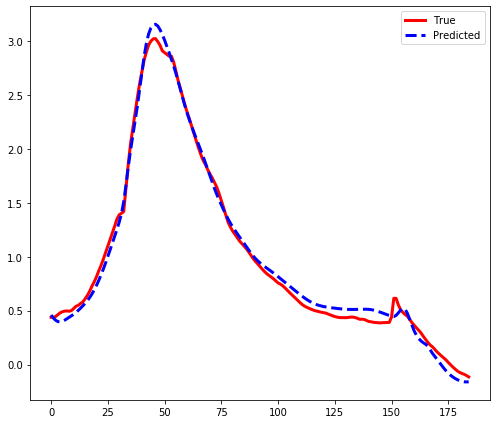

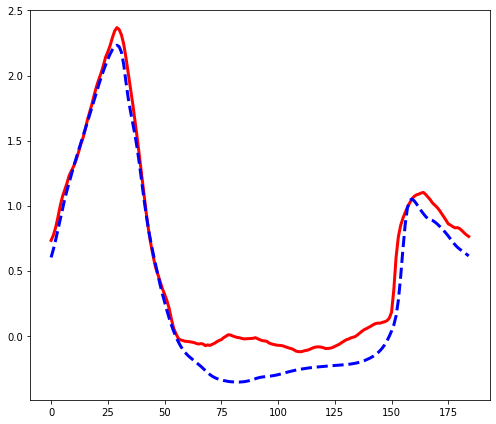

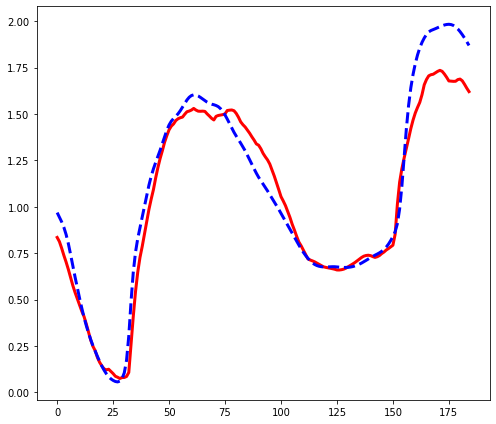

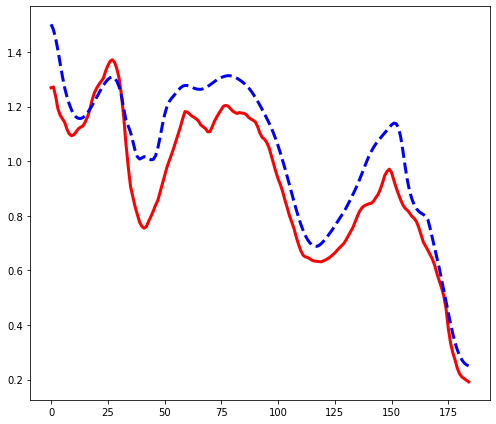

In [13]:
for i in range(4):
    plt.figure(figsize=(7,6))
    plt.plot(lstm_testing_data[time_window:,i],'r',label='True',linewidth=3)
    plt.plot(output_seq_pred[time_window:,i],'b--',label='Predicted',linewidth=3)
    
    if i == 0:
        plt.legend()
    plt.tight_layout()
    plt.show()

### Evolution in physical space

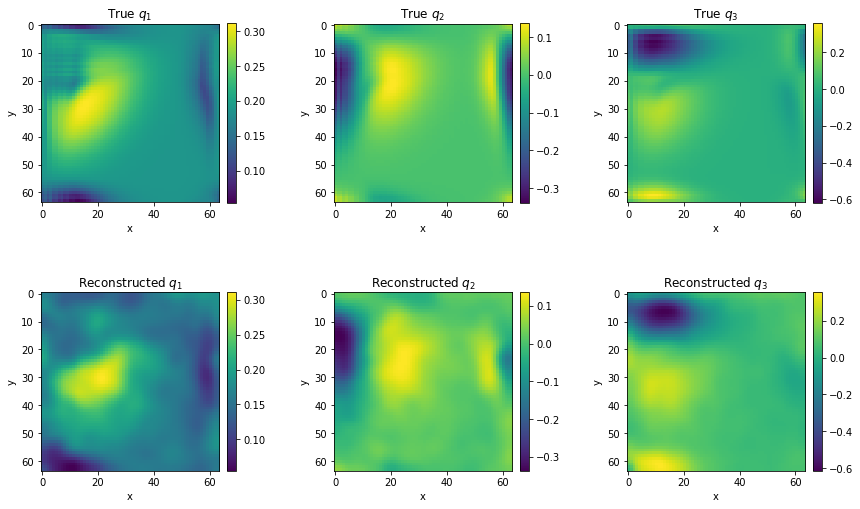

In [14]:
# Reshape for decoding
output_seq_pred = np.reshape(output_seq_pred,newshape=(200,2,2,1))
# Feed it through decoder
decoded_valid = K.eval(decoder(output_seq_pred.astype('float32')))

# Check evolution through spot checks
time = 50

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(14,12))
cs1 = ax[0,0].imshow(swe_valid_data[time,:,:,0],label='Truth')
ax[1,0].imshow(gaussian_filter(decoded_valid[time,:,:,0],sigma=2),label='Prediction')

cs2 = ax[0,1].imshow(swe_valid_data[time,:,:,1],label='Truth')
ax[1,1].imshow(gaussian_filter(decoded_valid[time,:,:,1],sigma=2),label='Prediction')

cs3 = ax[0,2].imshow(swe_valid_data[time,:,:,2],label='Truth')
ax[1,2].imshow(gaussian_filter(decoded_valid[time,:,:,2],sigma=2),label='Prediction')

for i in range(2):
    for j in range(3):
        ax[i,j].set_xlabel('x')
        ax[i,j].set_ylabel('y')
        
fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(cs1,ax=ax[1,0],fraction=0.046, pad=0.04)

fig.colorbar(cs2,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1,1],fraction=0.046, pad=0.04)

fig.colorbar(cs3,ax=ax[0,2],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[1,2],fraction=0.046, pad=0.04)


ax[0,0].set_title(r'True $q_1$')
ax[0,1].set_title(r'True $q_2$')
ax[0,2].set_title(r'True $q_3$')

ax[1,0].set_title(r'Reconstructed $q_1$')
ax[1,1].set_title(r'Reconstructed $q_2$')
ax[1,2].set_title(r'Reconstructed $q_3$')

plt.subplots_adjust(wspace=0.5,hspace=-0.3)
# plt.tight_layout()
plt.show()

### A posteriori analysis

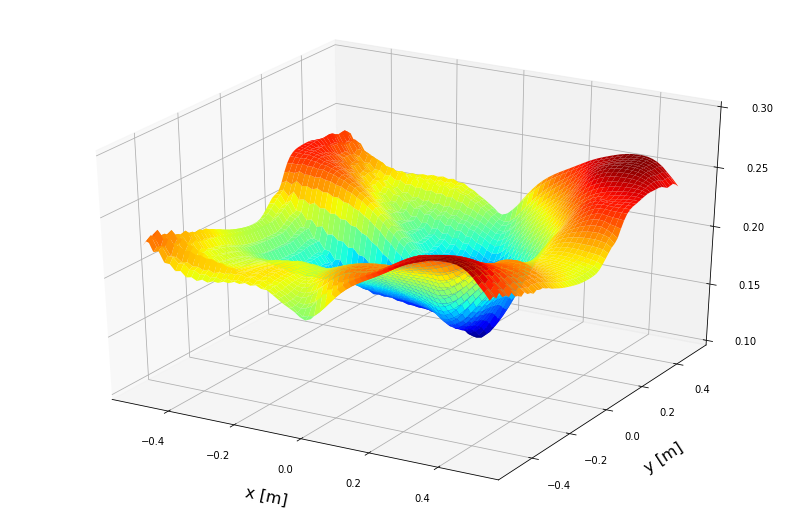

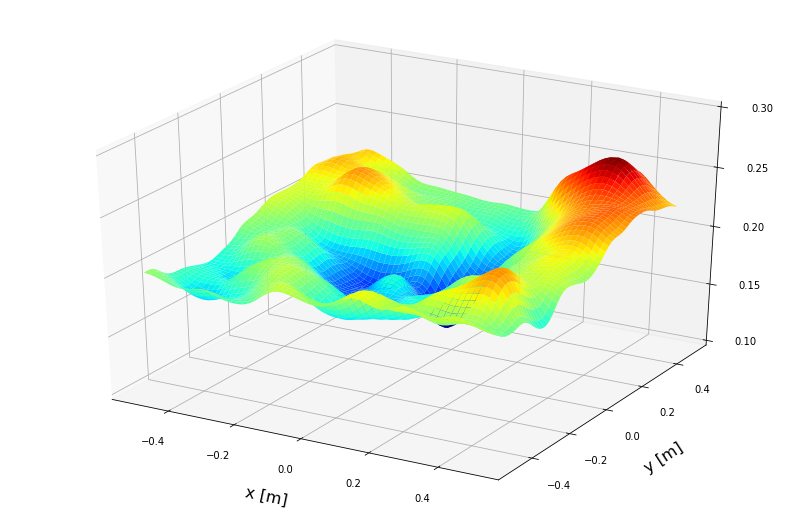

In [15]:
x = np.linspace(-1/2, 1/2, 64)  # Array with x-points
y = np.linspace(-1/2, 1/2, 64)  # Array with x-points

# Meshgrid for plotting
X, Y = np.meshgrid(x, y)
time = 199

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (11, 7))
ax = Axes3D(fig)
surf = ax.plot_surface(X, Y, swe_valid_data[time,:,:,0], rstride = 1, cstride = 1,
    cmap = plt.cm.jet, linewidth = 0, antialiased = True)

# ax.set_title('Visualization', fontname = "serif", fontsize = 17)
ax.set_xlabel('x [m]', fontsize = 16)
ax.set_ylabel('y [m]', fontsize = 16)

ax.xaxis.labelpad=30
ax.yaxis.labelpad=30

ax.xaxis.labelpad=30
ax.yaxis.labelpad=30

ax.tick_params(axis='both', which='major', pad=15)

ax.set_zticks([0.1, 0.15, 0.20, 0.25, 0.3])
ax.set_zlim((0.1,0.3))


plt.show()

fig = plt.figure(figsize = (11, 7))
ax = Axes3D(fig)
surf = ax.plot_surface(X, Y, gaussian_filter(decoded_valid[time,:,:,0],sigma=2), rstride = 1, cstride = 1,
    cmap = plt.cm.jet, linewidth = 0, antialiased = True)

# ax.set_title('Visualization', fontname = "serif", fontsize = 17)
ax.set_xlabel('x [m]', fontsize = 16)
ax.set_ylabel('y [m]', fontsize = 16)

ax.xaxis.labelpad=30
ax.yaxis.labelpad=30

ax.set_zticks([0.1, 0.15, 0.20, 0.25, 0.3])
ax.set_zlim((0.1,0.3))

ax.tick_params(axis='both', which='major', pad=15)
plt.show()